# EP 2
**Diogo José Costa Alves (13709881)**

In [2]:
cpu_info()

CPU(s):                          4
Nome do modelo:                  Intel(R) Core(TM) i5 CPU       M 520  @ 2.40GHz
Thread(s) per núcleo:            2


----
# Paralelizar o código para a simulação do LGA usando a biblioteca Pthreads e as diretivas de compilador fornecidas pelo OpenMP. 

**Resposta:**

A simulação da versão do LGA  define que o estado de cada célula do grid depende apenas do estado do instante anterior de algumas celulas vizinhas. 

Dessa forma, para paralelizar o algoritmo, mantemos a implementação sequencial da função ```simulate_{omp,pth}``` e nos concentramos em paralelizar o trabalho realizado pela função ```update``` nos arquivos ```lga_{omp,pth}.c```. 

## lga_omp.c
Na implementação da versao OpenMP foi adicionada a seguinte diretiva de compilação: 
```
    #pragma omp parallel for collapse(2) num_threads(num_threads)
```
Esta diretiva informa que os dois loops ```for``` que vem seguida, responsáveis for varrer todas as células do grid, devem ser paralelizados com o número máximo de threads definido na chamada da função.


## lga_pth.c
Já, na implementação Pthreads, foi necessário:

- Definir como as iterações dentro  dos ```for```s aninhados seriam divididas entre as diferentes threads.

- Definir a estrutura de informação disponibilizada para cada thread. (```struct thread_data```)

- Lançar as threads em paralelo. (Fork)

- Esperar que as threads, referentes ao instante do grid, terminem antes de começar o processamento do próximo instante. (Join)


----
# Medir o tempo de execução médio das três versões do programa para diferentes tamanhos de entrada (grid_size) e nas versões paralelizadas, para diferentes números de threads (num_threads)


A partir da combinação dos parâmetros de entrada ```grid_sizes``` e ```num_threads``` foi executado um experimento para medir o tempo de execução médio nas três implementações. 


Parâmetros:
```
grid_sizes = (32, 64, 128, 256, 512, 1024, 2048, 4096)
num_threads = (1, 2, 4, 8, 16, 32)
```


Para estimar o intervalo de confiança das amostras foi utilizado o Teorema do Limite Central .
O Teorema do Limite Central afirma que, se você obtiver uma quantidade de amostras suficientemente grande de qualquer população, a distribuição das médias amostrais será aproximadamente uma distribuição normal.
Observação: Quando não conhecemos a distribuição de origem, o **suficientemente grande** significa $n\ge30$. Caso a população de origem seja distribuída como uma normal, esse valor pode ser menor do que 30.


A partir dessa amostragem conseguimos realizar as seguinte inferências:


1. A distribuição das amostras será aproximadamente uma distribuição normal.


2. A distribuição das amostras tem uma média aproximadamente igual à média da população de origem.


3. A distribuição das amostras tem uma variância aproximadamente a variância da população de origem dividida pelo tamanho da amostra.


4. A distribuição das amostras tem um desvio padrão próximo ao desvio padrão da população de origem dividido pela raiz do tamanho da amostra.


Para o experimento, cada combinação de parâmetros foi avaliada 30 vezes ($n=30$). Para construção do baseline (implementação sequencial) foram colhidas 240 amostras. Para as duas implementações paralelas foram colhidas 2.880 amostras. Esses resultados foram salvos no arquivo: ```ep1_diogo_alves_results_raw.csv```.


Por fim, para cada combinação de parâmetros, foi calculada a média ($\mu$), desvio padrão ($\sigma$) e e intervalo de confiança de 95% ($\mu - \frac{1.96*\sigma}{\sqrt{n}}, \mu + \frac{1.96*\sigma}{\sqrt{n} }$) e salvo no arquivo ```ep1_diogo_alves_results_summary.csv```.


As Figuras abaixo, resumem os resultados de todas as execuções.
- As amostras (data points) estão destacadas com pontos vermelhos ('o') e representam os parâmetros testados.

- As linhas representam a interpolação das amostras coletadas.

- As áreas sombreadas representam o intevalo de confiança de 95%.

- O estilo da linha representa a implementação utilizada.


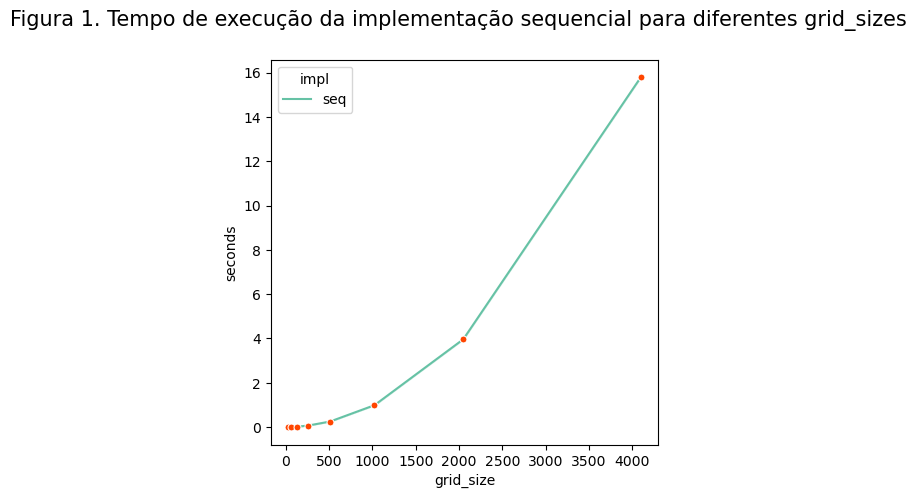

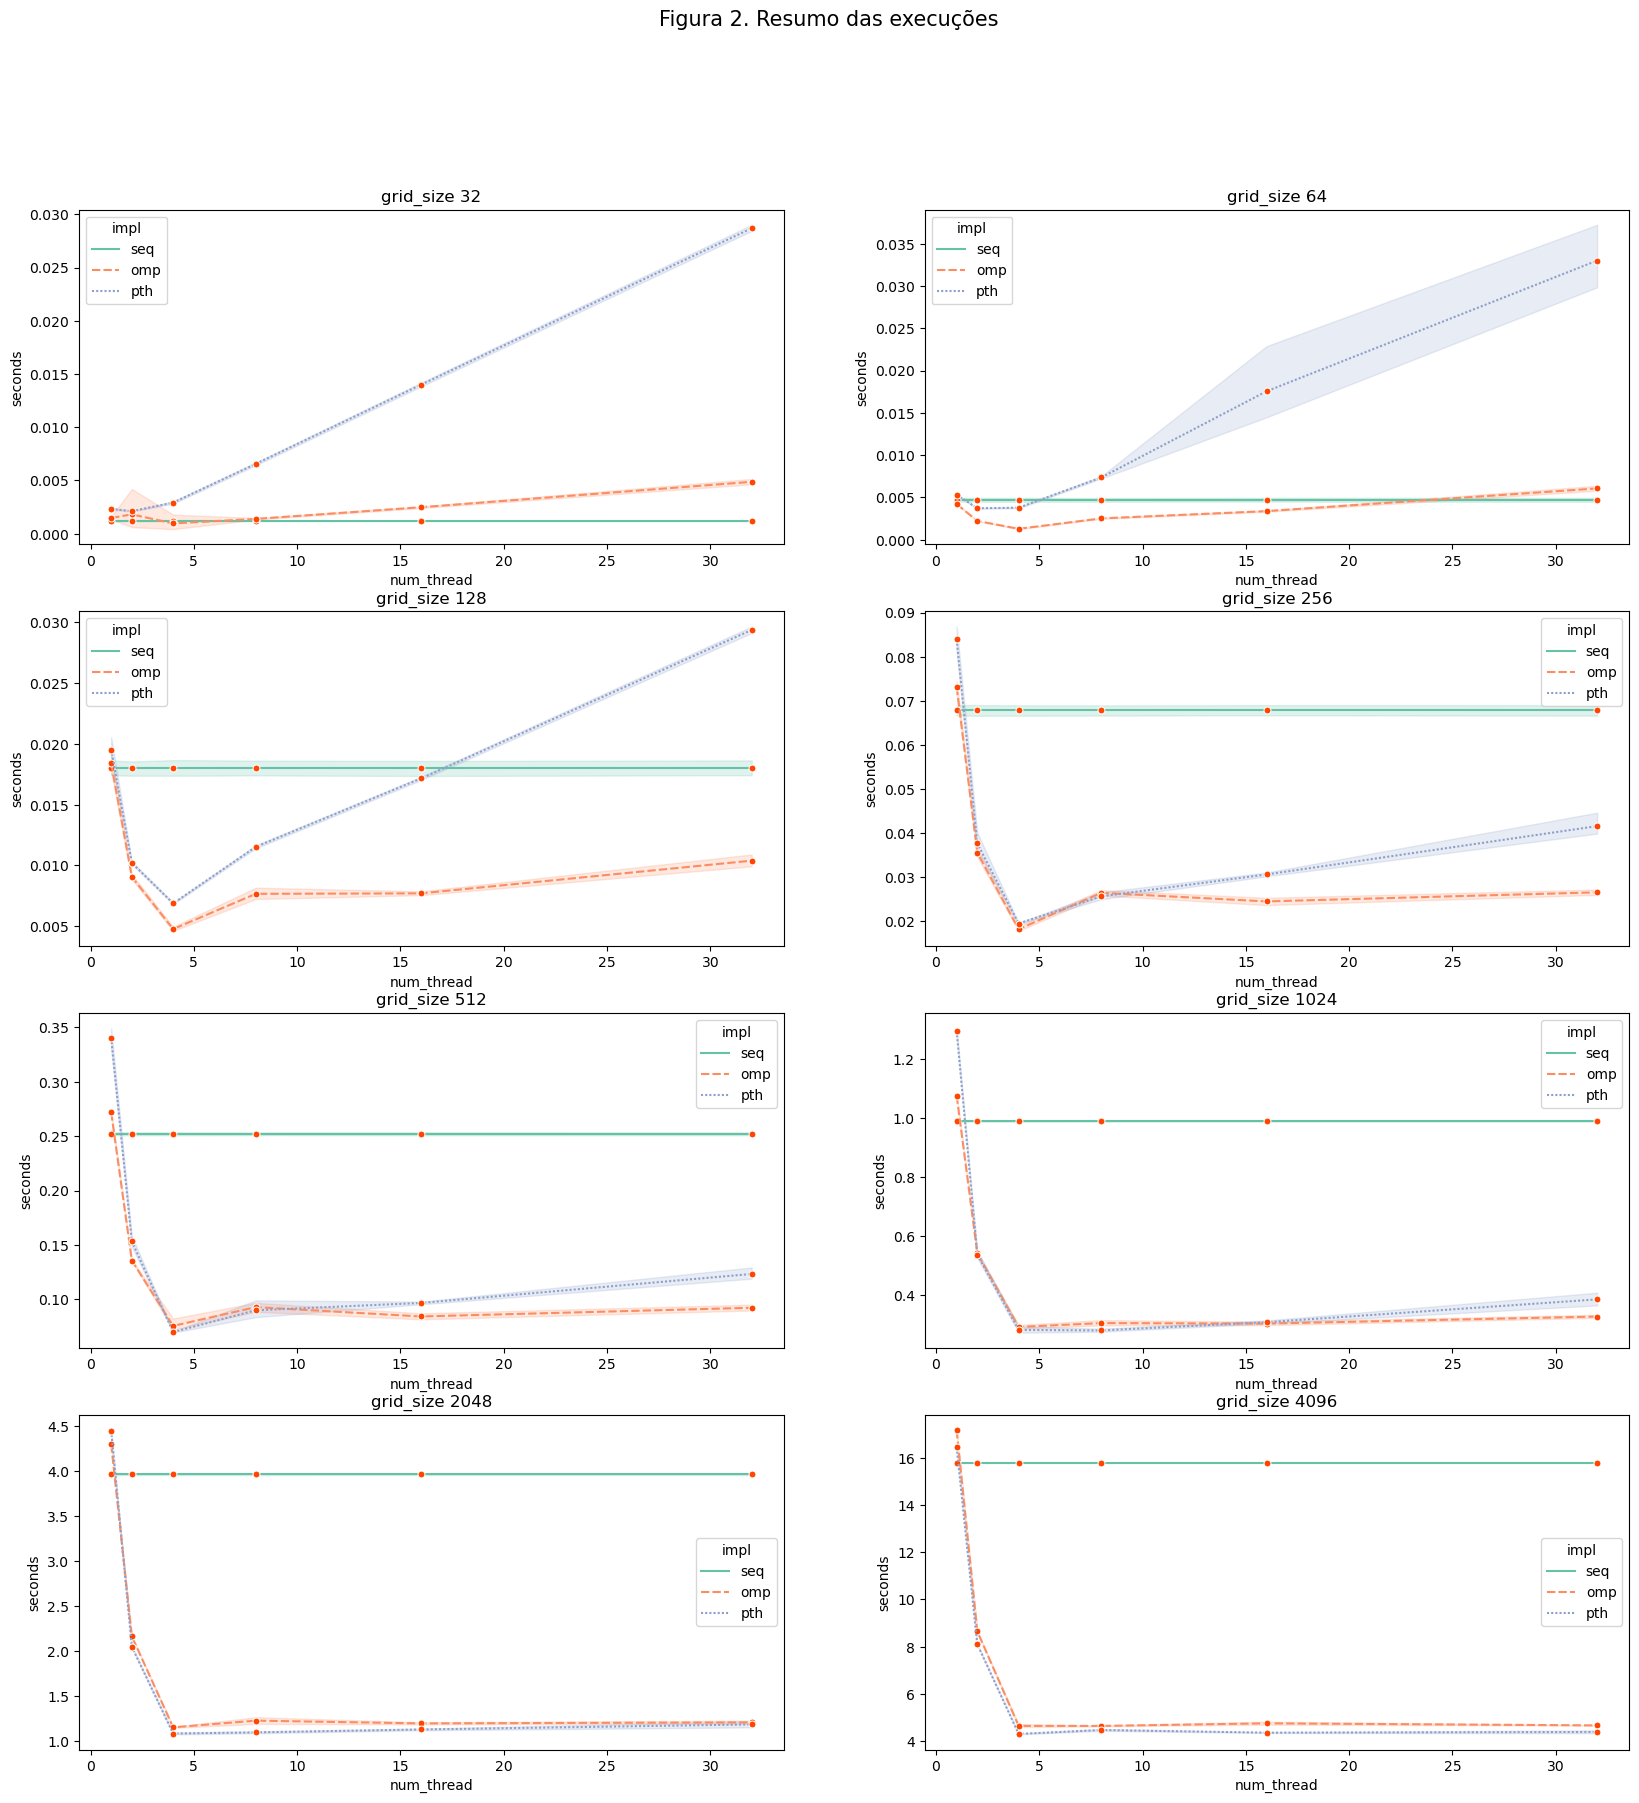

In [30]:
figuras()

----
# Como e por que as três versões do programa se comportam com a variação do tamanho da entrada e do número de threads.


**Resposta:**


A **Figura 1** resume os valores do tempo de execução da implementação sequencial para diferentes grid_sizes. Podemos perceber um crescimento maior que linear, possivelmente quadrático, no tempo de execução à medida que o grid_size aumenta. Esses valores são os esperados, vide os ```for```s aninhados na função ```update``` do arquivo ```lga_sec.c```.


A **Figura 2** resume os valores das três implementações, incluindo a informação do número de threads para as implementações paralelas. A linha referente a implementação sequencial oferece um baseline de comparação para os resultados das implementações paralelas.


Nessa figura:

- Cada ```subplot``` representa uma ```grid_size```.

- O eixo x representa o número de threads.

- O eixo y representa o tempo de execução médio em segundos.


## grid_sizes 512, 1024, 2048 e 4096
É possível perceber que o tempo médio de execução cai drasticamente nas implementações paralelas para ```num_threads``` igual 2 e 4. Para os outros valores de num_threads o tempo médio de execução parece convergir para um valor semelhante ao obtido quando são utilizados 4 threads. A justificativa para a observação é que a máquina utilizada na simulação executa as threads N lógicas definidas na chamada da aplicação utilizando a capacidade real da máquina que é de 4 threads reais.


## grid_sizes 32, 64, 128 e 256.
Para grid_sizes menores, as implementações paralelas apresentam regiões com desempenho inferior ao baseline sequencial. Essa evidência parece indicar que existem casos em que o overhead da criação e sincronização de threads foi maior ao ganho trazido na execução de forma paralela.


## Pthread vs OpenMP
Também é interessante notar que, para grid_sizes inferiores até 1024  a implementação com Pthreads possui alguns **data points** com um desempenho inferior ao da versão gerada através das diretivas OpenMP. Ao mesmo tempo, quando para grid_sizes superiores a 1024, possui a maioria dos **data points** com tempo médio de execução menores. Essas observacoes parecem indicar que:
Existe um espaço para otimizar a implementação em Pthreads de forma a reduzir o overhead de criação e sincronização de threads. 
O desempenho melhor da implementação baixo nível utilizando em Pthreads com grid_sizes maiores parece sugerir que seu overhead relativo por threads (overhead/threads) seria menor quando comparado ao overhead relativo da implementação que utiliza OpenMP.


----
# Anexos

### Código do experimento

In [5]:
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from os.path import exists

CSV_RAW_FILE = 'ep2_diogo_alves_results_raw.csv'
CSV_SUMMARY_FILE = 'ep2_diogo_alves_results_summary.csv'

array_size = (2**10, 2**11, 2**12, 2**13, 2**14, 2**15, 2**16, 2**17)
array_size_labels = ('2^10', '2^11', '2^12', '2^13', '2^14', '2^15', '2^16', '2^17')
np = (1, 2, 4, 8, 16, 32)
samples_per_evaluation = 11

def cpu_info(): 
  command = "lscpu | grep -Ei '^Cpu\(s\):|thread|core'"
  subprocess.Popen(command, shell=True).wait()
  return None

def make(debug=False):
  command = 'cd src/ && make clean && make'
  if debug: 
    command += f' debug'
  subprocess.Popen(command, shell=True, stdout=subprocess.DEVNULL).wait()
  return None

def check(grid_size, num_threads):
  cmd = ['./check', '--grid_size',  str(grid_size), '--num_threads', str(num_threads)]
  result = False
  with subprocess.Popen(cmd, stdout=subprocess.PIPE, cwd='src') as proc:
    output = str(proc.stdout.read())
    result = 'OpenMP igual ao sequencial' in output and 'Pthreads igual ao sequencial' in output
    return result

def check_all_combinations(grid_sizes, num_threads):
  total_evaluations = len(grid_sizes) * len(num_threads)
  with tqdm(total=total_evaluations) as pbar:
    for grid_size in grid_sizes:
      for num_thread in num_threads:
          is_OK = check(grid_size, num_thread)
          if not is_OK:
            print(f'Check failed for grid_size={grid_size} and num_thread={num_thread}!!!')
            return False
          pbar.update(1)
  print('Check passed for all combinations ✅✅✅')

def time_test(grid_size, impl, num_threads=1):
  cmd = ['./time_test', '--grid_size',  str(grid_size), '--impl', impl,'--num_threads', str(num_threads)]
  with subprocess.Popen(cmd, stdout=subprocess.PIPE, cwd='src') as proc:
    seconds = float(proc.stdout.read())
    return seconds

def add_95perc_confidence(row):
  interval = (1.96 * row['std'])/row['count']
  row['95_confidence_interval_min'] = row['mean'] - interval
  row['95_confidence_interval_max'] = row['mean'] + interval
  return row

def experiment(grid_sizes, num_threads, samples_per_evaluation):
  results = []

  # Baseline measurements
  total_baseline_evaluations = samples_per_evaluation * len(grid_sizes) 
  print(f'''
      grid_sizes: {grid_sizes}
      samples_per_evaluation: {samples_per_evaluation}
      total_baseline_evaluations: {total_baseline_evaluations }
      ''')
  with tqdm(total=total_baseline_evaluations) as pbar:
    for grid_size in grid_sizes:
      for _ in range(samples_per_evaluation):
        seconds = time_test(grid_size, 'seq')
        for num_thread in num_threads:
          results.append({'impl': 'seq', 'grid_size': grid_size, 'num_thread': num_thread, 'seconds': seconds})
        pbar.update(1)
  
  # Parallels implementations measurements
  impls = ('omp', 'pth')

  total_parallel_evaluations = samples_per_evaluation * len(grid_sizes) * len(num_threads) * len(impls)
  print(f'''
      impls: {impls}
      num_threads: {num_threads}
      total_parallels_evaluations: {total_parallel_evaluations} ''')
  
  with tqdm(total=total_parallel_evaluations) as pbar:
    for impl in impls:
      for grid_size in grid_sizes:
        for num_thread in num_threads:
          for _ in range(samples_per_evaluation):
            seconds = time_test(grid_size, impl, num_thread)
            results.append({'impl': impl, 'grid_size': grid_size, 'num_thread': num_thread, 'seconds': seconds})
            pbar.update(1)

  results = pd.DataFrame(results)
  results_summary = results.groupby(['impl', 'grid_size', 'num_thread'])['seconds'].describe()[['count', 'mean', 'std']].reset_index()
  results_summary = results_summary.apply(add_95perc_confidence, axis=1)
  results_summary = results_summary.astype({'impl': str, 'grid_size': int, 'num_thread': int, 'count': int})
  
  results.to_csv(CSV_RAW_FILE, index=False)
  results_summary.to_csv(CSV_SUMMARY_FILE, index=False)
  return (results, results_summary)


def reload_or_run(grid_sizes, num_threads, samples_per_evaluation):
  results_found = exists(CSV_RAW_FILE) and exists(CSV_SUMMARY_FILE)
  if results_found:
    print('Results found. Loading data to workspace...')
    results = pd.read_csv(CSV_RAW_FILE)
    results_summary = pd.read_csv(CSV_SUMMARY_FILE)
  else:
    print('Results NOT found. Starting the experiment...')
    results, results_summary = experiment(grid_sizes, num_threads, samples_per_evaluation)
  return (results, results_summary)

# 
# results, results_summary = reload_or_run(grid_sizes, num_threads, samples_per_evaluation)

In [6]:
make_debug()

FileNotFoundError: [Errno 2] No such file or directory: 'bash make clean'

In [ ]:
cpu

## Código gerador das figuras

In [26]:
def figura_1():
  fig , _= plt.subplots(figsize=(5,5))
  filtrado = results.loc[(results['impl']=='seq') & results['num_thread']==1]
  fig.suptitle("Figura 1. Tempo de execução da implementação sequencial para diferentes grid_sizes", fontsize=15)
  sns.lineplot(data=filtrado, x='grid_size', y='seconds', hue='impl', style='impl', marker='o', markerfacecolor='orangered', markersize=5, palette = "Set2")

def figura_2():
  fig, ax = plt.subplots(4,2,figsize=(20,20))
  fig.suptitle("Figura 2. Resumo das execuções", fontsize=15)
  for index in range(len(grid_sizes)):
    row = index//2
    col = index%2
    selected_grid = grid_sizes[index]
    filtrado = results.loc[results['grid_size'] == selected_grid]
    ax[row][col].title.set_text(f'grid_size {selected_grid}')
    sns.lineplot(data=filtrado, x='num_thread', y='seconds', hue='impl', style='impl', marker='o', markerfacecolor='orangered', markersize=5, palette = "Set2", ax=ax[row][col])
    
def figuras():
  figura_1()
  figura_2()